<a href="https://colab.research.google.com/github/Dilraj0/comp215/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EV Charging Station Optimization in Langley

**Team Members:**  


*   Dilraj Singh
*   Garvit Aneja




**Course:** COMP 215 1A/B

**Date:** April 2025


##  Problem Statement

As electric vehicles (EVs) become more common, cities must develop smart infrastructure to support them.  
One major challenge is identifying **the best locations** for EV charging stations so that they are **accessible**, **efficient**, and **evenly distributed**.

Poorly placed stations can lead to:
- Traffic congestion around high-demand areas
- Poor coverage in suburban or remote areas
- Long travel distances between stations

This project addresses the question:  
**Where should Langley place its top 5 EV charging stations for maximum efficiency and coverage?**

## STEPS OVERVIEW FOR THIS PROJECT

We followed a step-by-step approach to solve the EV station placement problem:

1. **Downloaded the Langley road network** using OSMnx and built a graph of intersections and roads.
2. **Computed 4 centrality measures**: Degree, Betweenness, Closeness, and Eigenvector — to rank nodes based on importance.
3. Selected the **top 5 nodes** from each method to visualize EV station placements.
4. Used **K-Means clustering** to compare with a location-based approach.
5. Simulated the **shortest paths** between stations to calculate travel distances and estimated time.
(first we will find the shortest path of K-mean clustering map which is more effective then after we will calculate shortest path of betweenness,closeness and combined centrality)
6. **Compared all methods** to analyze coverage vs. efficiency.
7. Made a final recommendation based on fairness and practicality.



##Download & Import Libraries

In [18]:
!pip install osmnx folium scikit-learn
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import itertools
import folium


## Downloading and Plotting Langley,Canada Map

In [19]:
place_name = "Langley, Canada"
print(f"Downloading road network for: {place_name}")#Downloading
G = ox.graph_from_place(place_name, network_type="drive")

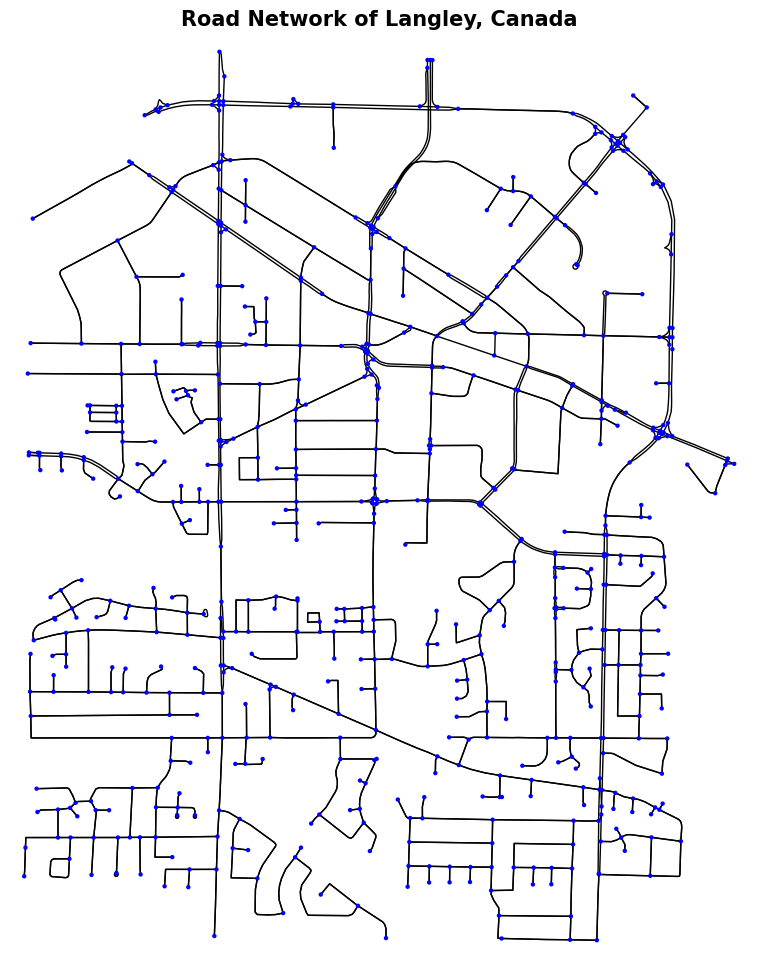

In [20]:
fig, ax = plt.subplots(figsize=(12, 12))
ox.plot_graph(G, ax=ax, node_size=10, node_color="blue", edge_color="black", bgcolor="white", show=False)#blue node color
ax.set_title(f"Road Network of {place_name}", fontsize=15, fontweight="bold")#plotting the road map
plt.show()


This map shows the road network of Langley.  
All the intersections (nodes) and roads (edges) are visualized here.  
We used this as the base graph to run all our centrality and clustering analysis.


## Centrality Measures: Degree, Betweenness, Closeness, Eigenvector



Now we will create a function which will calculate all 4 centrailty along with the combined centrailty.In the following cell we also convert mutligraph to digraph to prevent any calculation errors in eigenvector and creted database to store values that we will calculate.Eigenvector centrality sometimes fails to converge, especially on real-world graphs. We used a try-except block to catch that and keep the program stable without crashing.

###Centrality Measures Explained

We used four different centrality measures to analyze the importance of intersections in the city road network:

---

### 1. Degree Centrality  
This measures **how many direct roads connect to an intersection**.  
The more connections a node has, the more “active” or “busy” that spot is.

Real-life example: A roundabout or major crossroad that connects to many streets.

---

### 2. Betweenness Centrality  
This shows **how often a node lies on the shortest path between other nodes**.  
It helps identify intersections that act as **main routes** or **traffic bottlenecks**.

Real-life example: A highway exit that most cars pass through to reach different areas.

---

### 3. Closeness Centrality  
This measures **how quickly an intersection can reach all other intersections**.  
Nodes with high closeness are centrally located in terms of travel time.

Real-life example: A downtown location that’s easily reachable from anywhere in the city.

---

### 4. Eigenvector Centrality  
This shows **how well-connected a node is to other important nodes**.  
It doesn’t just look at the number of connections, but also **how influential those connections are**.

Real-life example: A major station that connects to other major hubs, not just small streets.

In [21]:
# creating a function to calculate 4 different types of centrality
def compute_centrality_measures(G):

    print("Computing centrality measures..")

    # Compute centrality measures
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G, weight="length", normalized=True, k=500)
    closeness_centrality = nx.closeness_centrality(G)

    # we convert multiDiGraph to DiGraph to prevent any calculation errors while finding eigenvenctor
    if isinstance(G, nx.MultiDiGraph):
        print("Converting MultiDiGraph to DiGraph to ensure proper eigenvector computation...")
        G = nx.DiGraph(G)  # Convert it to DiGraph

    # This code is necessary to run the cell without any crash as eigenvector sometimes fails to converge so it handles that
    try:
        eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=5000, tol=1e-04)
    except nx.PowerIterationFailedConvergence:
        print("Eigenvector centrality failed to converge. Setting values to 0.")
        eigenvector_centrality = {n: 0 for n in G.nodes()}

    # Create a DataFrame to store results
    df_centrality = pd.DataFrame({
        "Node": list(G.nodes()),
        "Degree Centrality": [degree_centrality.get(n, 0) for n in G.nodes()],
        "Betweenness Centrality": [betweenness_centrality.get(n, 0) for n in G.nodes()],
        "Closeness Centrality": [closeness_centrality.get(n, 0) for n in G.nodes()],
        "Eigenvector Centrality": [eigenvector_centrality.get(n, 0) for n in G.nodes()] })

    # MinMaxScaler normalize the values between 0 and 1 for fair comparison
    scaler = MinMaxScaler()
    df_centrality[["Degree Centrality", "Betweenness Centrality", "Closeness Centrality", "Eigenvector Centrality"]] = \
        scaler.fit_transform(df_centrality[["Degree Centrality", "Betweenness Centrality", "Closeness Centrality", "Eigenvector Centrality"]])

    # Add Combined Score (Mean of All Centralities)
    df_centrality["Combined Score"] = df_centrality[["Degree Centrality", "Betweenness Centrality", "Closeness Centrality", "Eigenvector Centrality"]].mean(axis=1)

    print("Centrality measures computed successfully!")
    return df_centrality

# Execute function and store the result
df_centrality = compute_centrality_measures(G)


Computing centrality measures..
Converting MultiDiGraph to DiGraph to ensure proper eigenvector computation...
Centrality measures computed successfully!


## Selecting Top EV Locations Based on Centrality


In next 2 cells we will store and display top 5 EV sttion locations based on betweenness, closeness and combimed of all four centrailty

In [22]:
def select_top_ev_locations(df_centrality):
    """
    Selects the top 5 EV station locations based on:
    - Betweenness Centrality
    - Closeness Centrality
    - Combined Score
    Returns three DataFrames containing the top 5 nodes for each method.
    """
    print("Selecting the best EV station locations...")

    # Top 5 based on different criteria
    df_top_betweenness = df_centrality.sort_values(by="Betweenness Centrality", ascending=False).head(5)
    df_top_closeness = df_centrality.sort_values(by="Closeness Centrality", ascending=False).head(5)
    df_top_combined = df_centrality.sort_values(by="Combined Score", ascending=False).head(5)

    print("Top EV locations selected.")
    return df_top_betweenness, df_top_closeness, df_top_combined

# Execute function and store results
df_top_betweenness, df_top_closeness, df_top_combined = select_top_ev_locations(df_centrality)


Selecting the best EV station locations...
Top EV locations selected.


In [23]:
# Display results
print("Top 5 EV Stations Based on Betweenness Centrality:")
display(df_top_betweenness)

print("\nTop 5 EV Stations Based on Closeness Centrality:")
display(df_top_closeness)

print("\nTop 5 EV Stations Based on Combined Score (Balanced Approach):")
display(df_top_combined)


Top 5 EV Stations Based on Betweenness Centrality:


,Node,Degree Centrality,Betweenness Centrality,Closeness Centrality,Eigenvector Centrality,Combined Score
576,4582033197,0.333333,1.000000,0.917390,0.036595,0.571830
493,2745419116,0.333333,0.961968,0.929703,0.050050,0.568763
125,416171631,1.000000,0.908141,0.870161,0.403536,0.795460
492,2745419114,0.666667,0.896858,0.921090,0.104967,0.647395
218,416174243,0.666667,0.775883,0.958707,0.153782,0.638759



Top 5 EV Stations Based on Closeness Centrality:


,Node,Degree Centrality,Betweenness Centrality,Closeness Centrality,Eigenvector Centrality,Combined Score
412,416179564,0.666667,0.619828,1.000000,0.265298,0.637948
465,2656530346,1.000000,0.382015,0.997639,0.997984,0.844410
466,2656530349,0.666667,0.416750,0.997050,0.525175,0.651411
51,416169271,0.666667,0.300391,0.978578,0.631326,0.644240
389,416178930,0.666667,0.059761,0.973730,0.890971,0.647782



Top 5 EV Stations Based on Combined Score (Balanced Approach):


,Node,Degree Centrality,Betweenness Centrality,Closeness Centrality,Eigenvector Centrality,Combined Score
465,2656530346,1.0,0.382015,0.997639,0.997984,0.844410
282,416176068,1.0,0.406051,0.921793,1.000000,0.831961
125,416171631,1.0,0.908141,0.870161,0.403536,0.795460
400,416179297,1.0,0.748715,0.861468,0.467421,0.769401
108,416171271,1.0,0.376605,0.913424,0.784487,0.768629


##Visualizing Top 5 EV station based on centrality and combined score

**1. Betweenness Centrality Map**

Visualizing EV stations based on Betweenness Centrality...


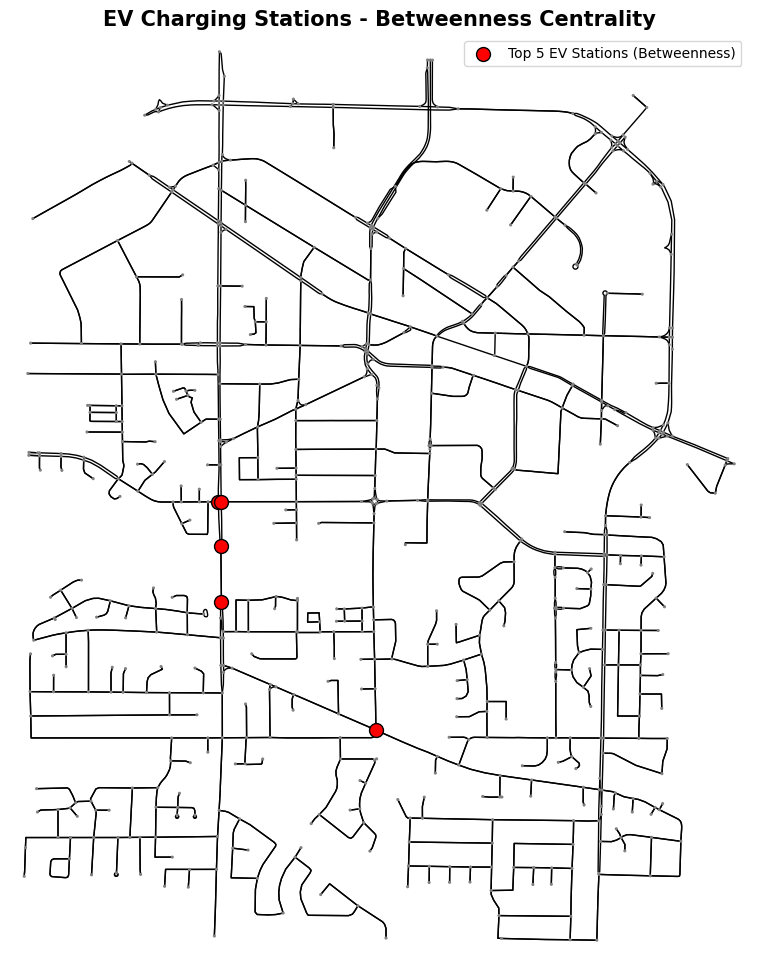

Visualization Complete!


In [24]:
def visualize_betweenness(G, df_top_betweenness):
    """
    Visualizes the Top 5 EV station locations based on Betweenness Centrality.
    """
    print("Visualizing EV stations based on Betweenness Centrality...")

    # Extract coordinates
    bet_x, bet_y = zip(*[(G.nodes[n]["x"], G.nodes[n]["y"]) for n in df_top_betweenness["Node"].tolist()])

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 12))

    # Plot base road network
    ox.plot_graph(G, ax=ax, node_size=5, node_color="gray", edge_color="black", show=False)

    # Plot EV station locations
    ax.scatter(bet_x, bet_y, c="red", s=100, label="Top 5 EV Stations (Betweenness)", edgecolors="black", zorder=3)

    # Set title and show
    ax.set_title("EV Charging Stations - Betweenness Centrality", fontsize=15, fontweight="bold")
    ax.legend()
    plt.show()

    print("Visualization Complete!")


# Run function
visualize_betweenness(G, df_top_betweenness)


**Explanation:**  
This map visualize top 5 betweenness centrality points in the map.The points seems clstered and overlaped in center area

**2.Closeness Centrality Map**

Visualizing EV stations based on Closeness Centrality...


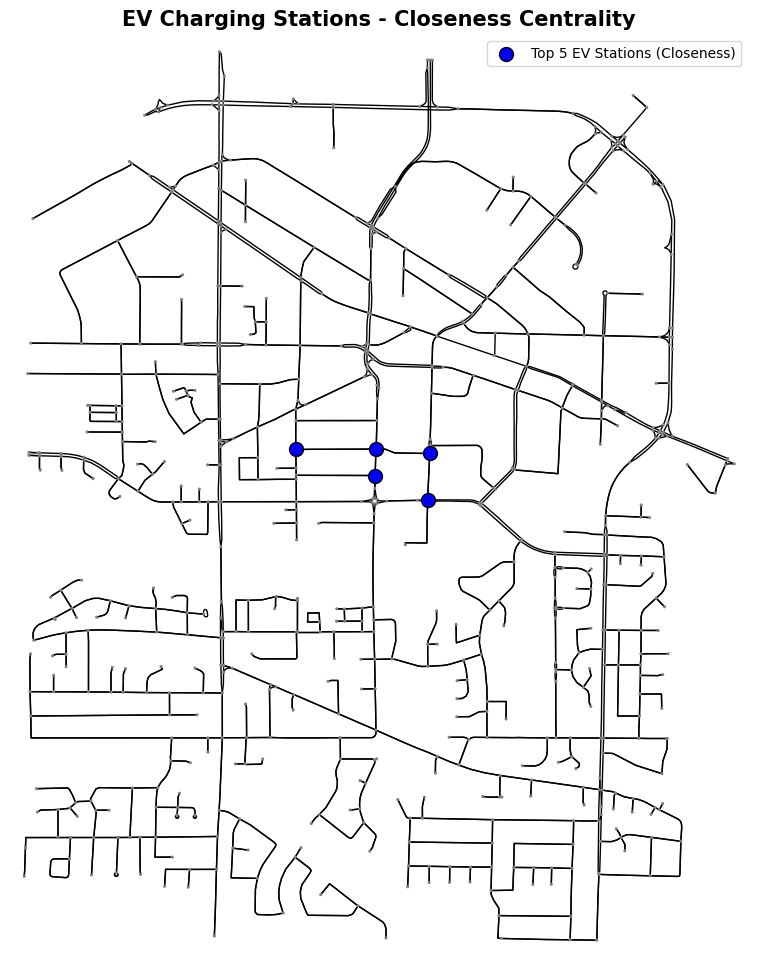

Visualization Complete!


In [25]:
def visualize_closeness(G, df_top_closeness):
    """
    Visualizes the Top 5 EV station locations based on Closeness Centrality.
    """
    print("Visualizing EV stations based on Closeness Centrality...")

    # Extract coordinates
    clos_x, clos_y = zip(*[(G.nodes[n]["x"], G.nodes[n]["y"]) for n in df_top_closeness["Node"].tolist()])

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 12))

    # Plot base road network
    ox.plot_graph(G, ax=ax, node_size=5, node_color="gray", edge_color="black", show=False)

    # Plot EV station locations
    ax.scatter(clos_x, clos_y, c="blue", s=100, label="Top 5 EV Stations (Closeness)", edgecolors="black", zorder=3)

    # Set title and show
    ax.set_title("EV Charging Stations - Closeness Centrality", fontsize=15, fontweight="bold")
    ax.legend()
    plt.show()

    print("Visualization Complete!")

# Run function
visualize_closeness(G, df_top_closeness)


**Explanation:**  
Closeness centrality highlights nodes that can **reach all other intersections quickly**.  
Perfect for **centralized accessibility**.


**3. Visualize EV Stations Selected by Combined Score**

📍 Visualizing EV stations based on Combined Score...


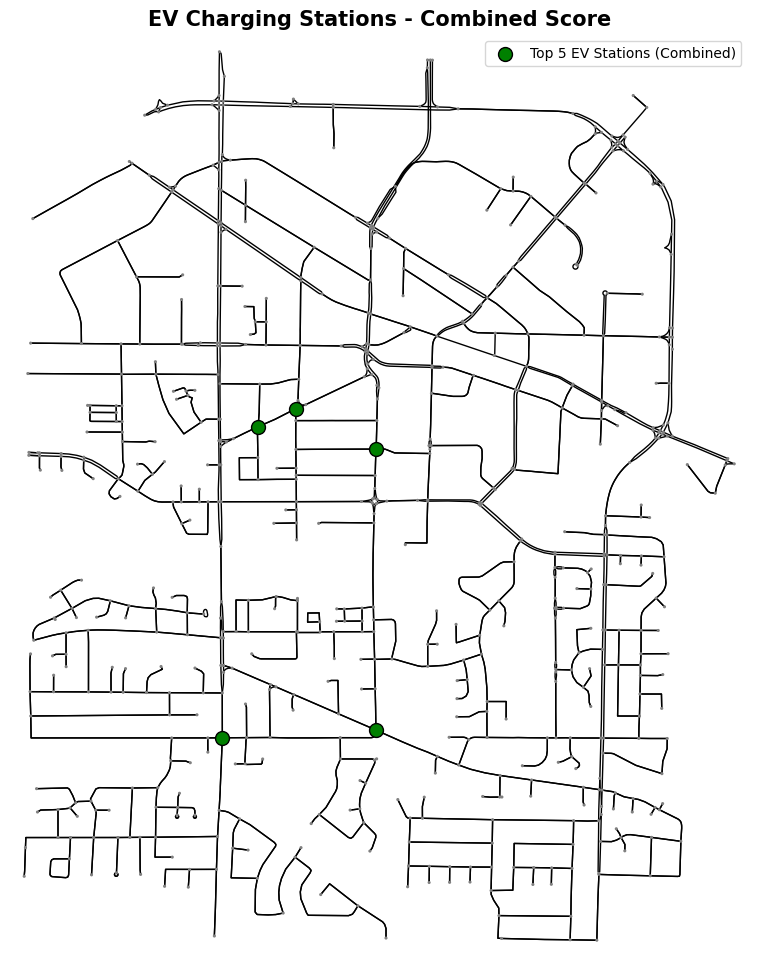

Visualization Complete!


In [26]:
def visualize_combined(G, df_top_combined):
    """
    Visualizes the Top 5 EV station locations based on the Combined Centrality Score.
    """
    print("📍 Visualizing EV stations based on Combined Score...")

    # Extract coordinates
    comb_x, comb_y = zip(*[(G.nodes[n]["x"], G.nodes[n]["y"]) for n in df_top_combined["Node"].tolist()])

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 12))

    # Plot base road network
    ox.plot_graph(G, ax=ax, node_size=5, node_color="gray", edge_color="black", show=False)

    # Plot EV station locations
    ax.scatter(comb_x, comb_y, c="green", s=100, label="Top 5 EV Stations (Combined)", edgecolors="black", zorder=3)

    # Set title and show
    ax.set_title("EV Charging Stations - Combined Score", fontsize=15, fontweight="bold")
    ax.legend()
    plt.show()

    print("Visualization Complete!")

# Run function
visualize_combined(G, df_top_combined)


This map shows the top 5 intersections selected using the average of all four centrality scores.  
It combines Degree, Betweenness, Closeness, and Eigenvector centrality to give a more balanced and fair result.  
However, the stations are still mostly placed in central areas, which means **some parts of the city are left out**.


##Comparing all Centrality and combined results in one Visualization map

Comparing all EV station selection methods...


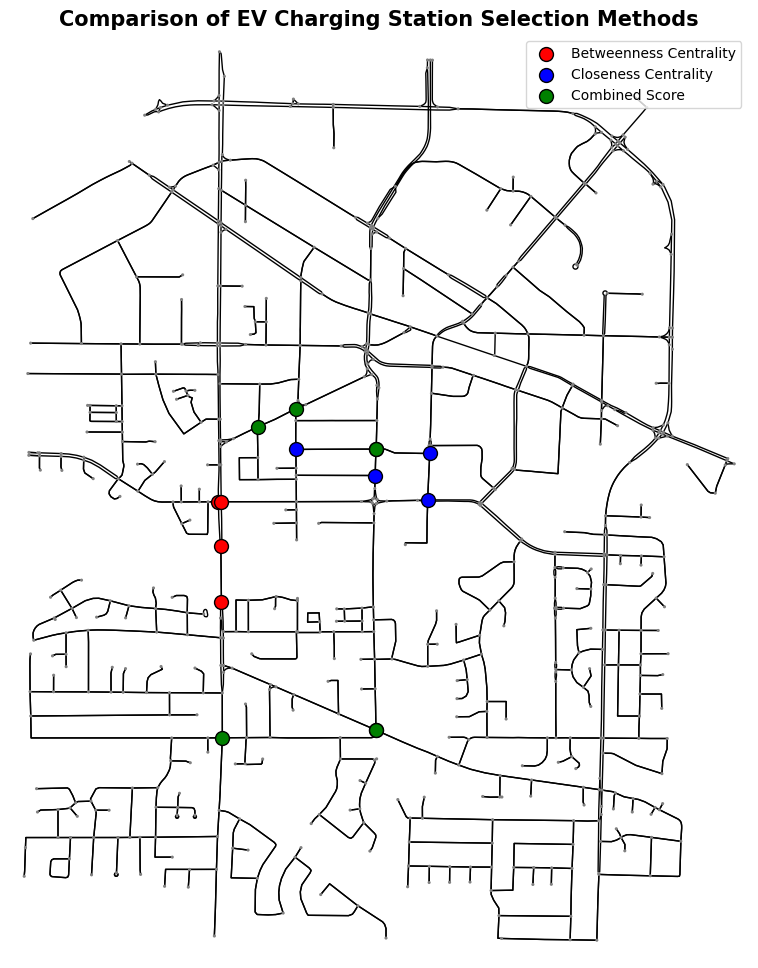

Comparison visualization complete!


In [27]:
def compare_ev_methods(G, df_top_betweenness, df_top_closeness, df_top_combined):
    """
    Compares all three EV station selection methods in one graph with color coding.
    """
    print("Comparing all EV station selection methods...")

    # Extract coordinates for each method
    bet_x, bet_y = zip(*[(G.nodes[n]["x"], G.nodes[n]["y"]) for n in df_top_betweenness["Node"].tolist()])
    clos_x, clos_y = zip(*[(G.nodes[n]["x"], G.nodes[n]["y"]) for n in df_top_closeness["Node"].tolist()])
    comb_x, comb_y = zip(*[(G.nodes[n]["x"], G.nodes[n]["y"]) for n in df_top_combined["Node"].tolist()])

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 12))

    # Plot base road network
    ox.plot_graph(G, ax=ax, node_size=5, node_color="gray", edge_color="black", show=False)

    # Plot EV stations with different colors
    ax.scatter(bet_x, bet_y, c="red", s=100, label="Betweenness Centrality", edgecolors="black", zorder=3)
    ax.scatter(clos_x, clos_y, c="blue", s=100, label="Closeness Centrality", edgecolors="black", zorder=3)
    ax.scatter(comb_x, comb_y, c="green", s=100, label="Combined Score", edgecolors="black", zorder=3)

    # Set title, legend, and show
    ax.set_title("Comparison of EV Charging Station Selection Methods", fontsize=15, fontweight="bold")
    ax.legend()
    plt.show()

    print("Comparison visualization complete!")

# Run function
compare_ev_methods(G, df_top_betweenness, df_top_closeness, df_top_combined)


**Why we did not vizualize Degree and Eigenvector Centrality?**

While we calculated both **Degree** and **Eigenvector Centrality**, we decided not to visualize them separately. Here's why:

- **Degree Centrality** highlights intersections with the most direct road connections. But in our case, these points were mostly clustered in central zones and didn’t offer much new insight compared to Betweenness and Closeness.

- **Eigenvector Centrality** focuses on “influential” intersections — ones connected to other important nodes. However, it often overlaps with the results from Closeness and doesn't clearly show geographic spread.

So instead of repeating similar maps, we included these scores in our **Combined Score**, which balances all four centralities in a single, fair metric.

The goal was to avoid redundancy and keep the visuals focused and meaningful.


##Step:2 of the project
##Using K-mean clustering to find the Top 5 Ev


### What is K-Means Clustering?

K-Means is a simple machine learning algorithm used to divide locations into groups (called clusters) based on how close they are to each other.

In our project, we used K-Means to group intersections in Langley into **5 regions**, so we could place one EV charging station in the center of each group.

 This method doesn’t care about traffic or centrality — it only focuses on **spreading the stations out evenly across the city**.

The goal was to make sure that all parts of Langley — not just the downtown area — have access to at least one nearby EV charging station.


First we will get coordinates of all intersection in the map

In [28]:
def get_intersection_coordinates(G):
    """
    Extracts intersection coordinates from the road network graph G.
    Returns a DataFrame containing node IDs and their latitude/longitude.
    """
    node_data = []

    for node, data in G.nodes(data=True):
        node_data.append([node, data['y'], data['x']])

    df_nodes = pd.DataFrame(node_data, columns=["Node", "Latitude", "Longitude"])
    return df_nodes

# Get intersection coordinates
df_nodes = get_intersection_coordinates(G)
df_nodes.head()


,Node,Latitude,Longitude
0,249653239,49.104667,-122.656299
1,249653637,49.107254,-122.651930
2,260418469,49.113352,-122.669187
3,265693994,49.101791,-122.645458
4,265693999,49.106866,-122.664096


Apply K-Means Clustering

In [29]:
def cluster_intersections(df_nodes, num_clusters=5):
    """
    Applies K-Means clustering to spread out EV station placement.
    Returns a DataFrame with cluster labels and selected representative nodes.
    """

    # Extract coordinates for clustering
    coordinates = df_nodes[["Latitude", "Longitude"]].values

    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    df_nodes["Cluster"] = kmeans.fit_predict(coordinates)

    # Select one representative intersection per cluster
    selected_stations = df_nodes.groupby("Cluster").first().reset_index()

    print("Clustering complete! Selected EV station locations:")
    return selected_stations

# Run clustering to get 5 optimized EV station locations
df_clustered_stations = cluster_intersections(df_nodes, num_clusters=5)
df_clustered_stations


Clustering complete! Selected EV station locations:


,Cluster,Node,Latitude,Longitude
0,0,266680718,49.096456,-122.646544
1,1,275052935,49.082147,-122.669056
2,2,249653239,49.104667,-122.656299
3,3,260418469,49.113352,-122.669187
4,4,249653637,49.107254,-122.651930


Visualizing optimized EV charging station locations (K-Means Clustering)...


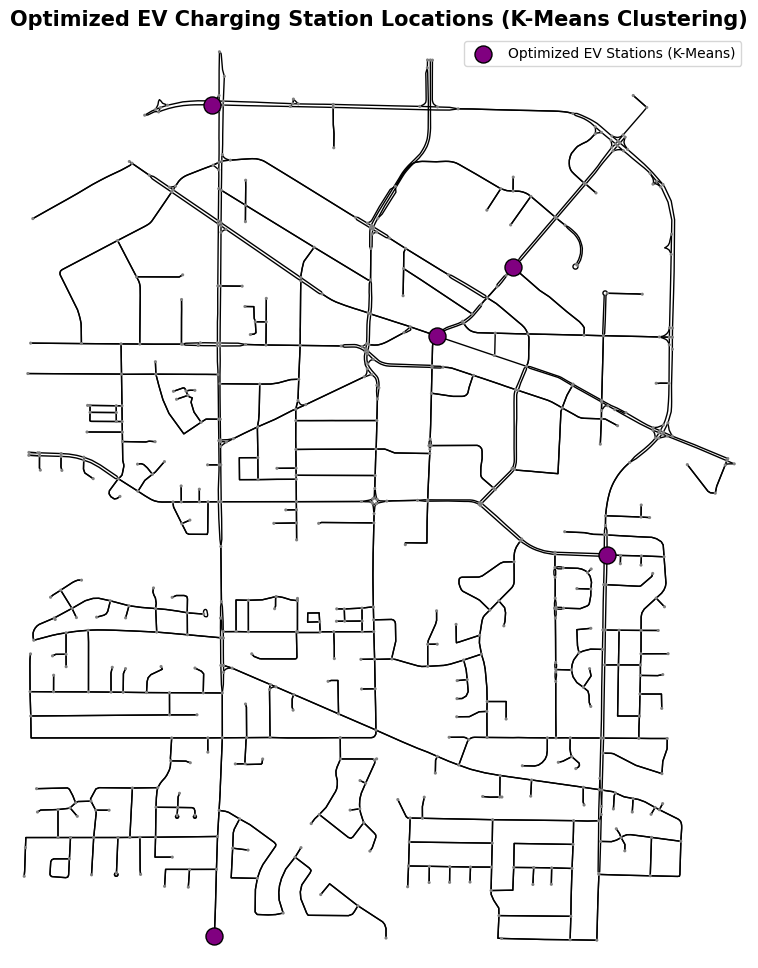

Visualization complete!


In [31]:
def visualize_clustered_ev_stations(G, df_clustered_stations):
    """
    Visualizes the K-Means clustered EV stations on the road network.
    """
    print("Visualizing optimized EV charging station locations (K-Means Clustering)...")

    # Extract node coordinates
    ev_x, ev_y = df_clustered_stations["Longitude"], df_clustered_stations["Latitude"]

    # Create figure for visualization
    fig, ax = plt.subplots(figsize=(12, 12))

    # Plot base road network
    ox.plot_graph(G, ax=ax, node_size=5, node_color="gray", edge_color="black", show=False)

    # Overlay EV station locations
    ax.scatter(ev_x, ev_y, c="purple", s=150, label="Optimized EV Stations (K-Means)", edgecolors="black", zorder=3)

    # Final plot adjustments
    ax.set_title("Optimized EV Charging Station Locations (K-Means Clustering)", fontsize=15, fontweight="bold")
    ax.legend()
    plt.show()

    print("Visualization complete!")

# Run function to visualize optimized EV locations
visualize_clustered_ev_stations(G, df_clustered_stations)


## Comparing all centrality map with k-mean clustering visualization

Comparing K-Means vs. Centrality-Based EV Station Placements...


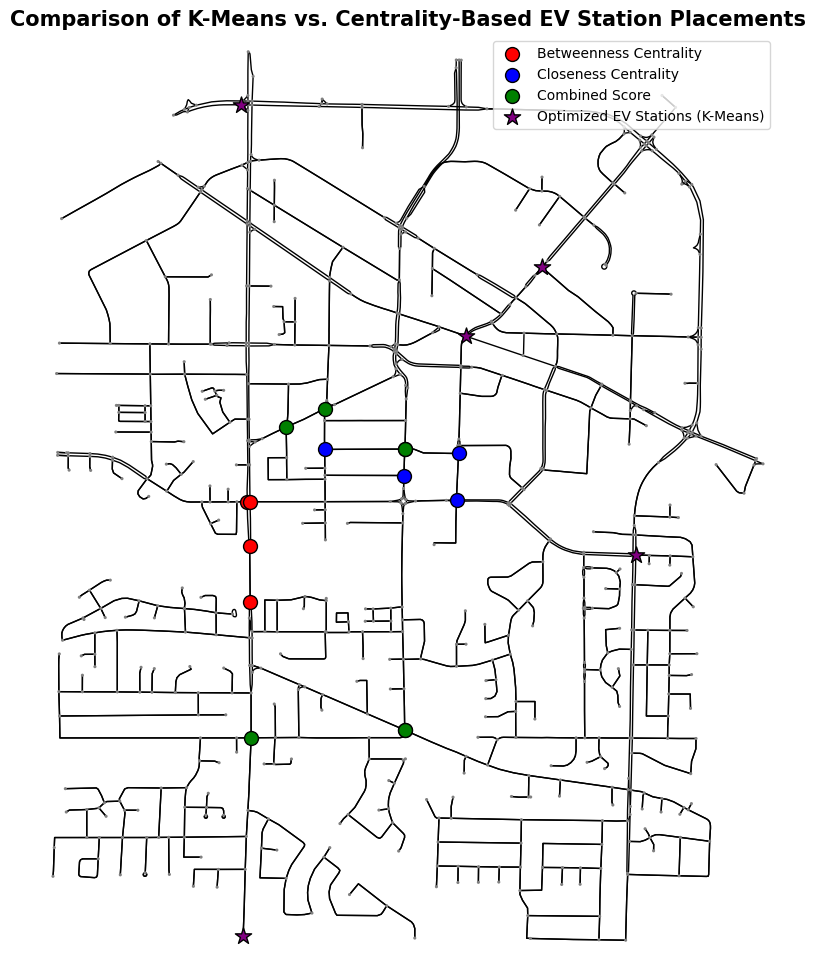

Comparison visualization complete!


In [32]:
def compare_kmeans_vs_centrality(G, df_top_betweenness, df_top_closeness, df_top_combined, df_clustered_stations):
    """
    Compares K-Means optimized EV stations vs. Centrality-Based selections in a single graph with color coding.
    """
    print("Comparing K-Means vs. Centrality-Based EV Station Placements...")

    # Extract coordinates for each method
    bet_x, bet_y = zip(*[(G.nodes[n]["x"], G.nodes[n]["y"]) for n in df_top_betweenness["Node"].tolist()])
    clos_x, clos_y = zip(*[(G.nodes[n]["x"], G.nodes[n]["y"]) for n in df_top_closeness["Node"].tolist()])
    comb_x, comb_y = zip(*[(G.nodes[n]["x"], G.nodes[n]["y"]) for n in df_top_combined["Node"].tolist()])
    kmeans_x, kmeans_y = df_clustered_stations["Longitude"], df_clustered_stations["Latitude"]

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 12))

    # Plot base road network
    ox.plot_graph(G, ax=ax, node_size=5, node_color="gray", edge_color="black", show=False)

    # Plot EV stations with different colors
    ax.scatter(bet_x, bet_y, c="red", s=100, label="Betweenness Centrality", edgecolors="black", zorder=3)
    ax.scatter(clos_x, clos_y, c="blue", s=100, label="Closeness Centrality", edgecolors="black", zorder=3)
    ax.scatter(comb_x, comb_y, c="green", s=100, label="Combined Score", edgecolors="black", zorder=3)
    ax.scatter(kmeans_x, kmeans_y, c="purple", s=150, marker="*", label="Optimized EV Stations (K-Means)", edgecolors="black", zorder=3)

    # Set title, legend, and show plot
    ax.set_title("Comparison of K-Means vs. Centrality-Based EV Station Placements", fontsize=15, fontweight="bold")
    ax.legend()
    plt.show()

    print("Comparison visualization complete!")

#run the function
compare_kmeans_vs_centrality(G, df_top_betweenness, df_top_closeness, df_top_combined, df_clustered_stations)


This visual clearly shows the **difference in placement style** —  
Centrality = efficient but clustered  
K-Means = balanced and well-distributed

##Compute Shortest Paths Between K-Means EV Stations

In [33]:
def compute_kmeans_shortest_paths(G, df_clustered_stations):
    """
    Computes shortest paths between the K-Means optimized EV stations.
    Returns a list of shortest paths.
    """

    # Extract the node list for shortest path calculations
    kmeans_station_nodes = []

    # Find the closest nodes in G for the K-Means station locations
    for i, row in df_clustered_stations.iterrows():
        nearest_node = ox.distance.nearest_nodes(G, row["Longitude"], row["Latitude"])
        kmeans_station_nodes.append(nearest_node)

    # Generate all possible pairs of stations
    station_pairs = list(itertools.combinations(kmeans_station_nodes, 2))

    shortest_paths = []

    for source, target in station_pairs:
        if nx.has_path(G, source, target):
            path = nx.shortest_path(G, source=source, target=target, weight="length")
            shortest_paths.append((source, target, path))
        else:
            print(f"No path found between Node {source} and Node {target}, skipping.")

    print("Shortest paths computed successfully!")
    return shortest_paths, kmeans_station_nodes

# Run the function to compute shortest paths for K-Means stations
shortest_paths_kmeans, kmeans_station_nodes = compute_kmeans_shortest_paths(G, df_clustered_stations)


Shortest paths computed successfully!


Visualize Shortest Paths Between K-Means Stations

In [34]:
import pandas as pd

def display_shortest_paths_table(shortest_paths_kmeans):
    """
    Displays the computed shortest paths between K-Means EV stations as a DataFrame.
    """

    # Create a list of paths with source, target, and number of steps
    path_data = []
    for source, target, path in shortest_paths_kmeans:
        path_data.append({
            "Source": source,
            "Target": target,
            "Path Length (Nodes)": len(path),
            "Path": path})

    # Convert to DataFrame for better viewing
    df_paths = pd.DataFrame(path_data)

    display(df_paths)

    print("Shortest paths displayed successfully!")

# Run function to check computed paths
display_shortest_paths_table(shortest_paths_kmeans)

,Source,Target,Path Length (Nodes),Path
0,266680718,275052935,24,"[266680718, 416171664, 416176576, 416174030, 4..."
1,266680718,249653239,15,"[266680718, 416171664, 416176576, 416174030, 3..."
2,266680718,260418469,31,"[266680718, 416171664, 416176576, 416174030, 3..."
3,266680718,249653637,15,"[266680718, 416170367, 4592782687, 1138743448,..."
4,275052935,249653239,30,"[275052935, 416179823, 416172405, 416172358, 4..."
5,275052935,260418469,36,"[275052935, 416179823, 416172405, 416172358, 4..."
6,275052935,249653637,36,"[275052935, 416179823, 416172405, 416172358, 4..."
7,249653239,260418469,17,"[249653239, 2742894475, 2742882763, 2737772311..."
8,249653239,249653637,7,"[249653239, 416177791, 11407853638, 416175733,..."
9,260418469,249653637,16,"[260418469, 2549455941, 2410025597, 2737772572..."


Shortest paths displayed successfully!


vizulatising the shorest path by using folium

In [35]:

def visualize_paths_folium(G, df_clustered_stations, shortest_paths_kmeans):
    """
    Uses Folium to visualize the shortest paths between K-Means optimized EV stations on an interactive map.
    """
    # Get the center of the map from the first station
    start_node = df_clustered_stations['Node'].iloc[0]
    start_lat, start_lon = G.nodes[start_node]["y"], G.nodes[start_node]["x"]

    # Create the folium map
    m = folium.Map(location=[start_lat, start_lon], zoom_start=13)

    # Add EV charging station markers
    for i, row in df_clustered_stations.iterrows():
        folium.Marker(
            location=[row["Latitude"], row["Longitude"]],
            popup=f"EV Station {row['Node']}",
            icon=folium.Icon(color="purple", icon="bolt", prefix="fa"),
        ).add_to(m)

    # Draw the shortest paths
    for source, target, path in shortest_paths_kmeans:
        route_coords = [(G.nodes[n]["y"], G.nodes[n]["x"]) for n in path]
        folium.PolyLine(route_coords, color="blue", weight=4, opacity=0.7).add_to(m)
    return m

# Run function to visualize
visualize_paths_folium(G, df_clustered_stations, shortest_paths_kmeans)

Next Step: Analyzing Travel Distance & Time

**Shortest Route:**

The quickest travel time is 0.66 minutes (40 seconds) between Nodes 249653239 & 249653637 (only 442 meters apart).
This suggests these two stations might be too close—we could remove one and replace it elsewhere.

**Longest Route:**

The longest route is 3999.22 meters (4 km) with a 6-minute travel time between 275052935 & 260418469.
This is still reasonable, meaning no two stations are too far apart.

**Average Travel Distance Between Stations:**

The average distance is around 2-4 km, which is good for urban areas.

**Are the Stations Efficiently Placed?**

If most stations are under 5 km apart, it means good coverage for EV drivers.
But stations too close (under 500m) might not be necessary and should be repositioned.


##for Comparison finding shortest distance of centrality  Extract the Top 5 Centrality-Based EV Stations

In [36]:
# Select the top 5 EV station locations based on different criteria
df_top_betweenness = df_centrality.nlargest(5, "Betweenness Centrality")
df_top_closeness = df_centrality.nlargest(5, "Closeness Centrality")
df_top_combined = df_centrality.nlargest(5, "Combined Score")

print("Top 5 EV stations selected based on different centrality methods!")


Top 5 EV stations selected based on different centrality methods!


 Step 2: Compute Shortest Paths for Centrality-Based Stations
Run this to find the shortest paths between these EV stations

In [37]:
def compute_centrality_shortest_paths(G, df_top_stations, df_nodes): # Add df_nodes as an argument
    """
    Computes shortest paths between Centrality-Based EV stations.
    Returns a list of shortest paths.
    """

    # Extract nodes for shortest path calculations
    centrality_station_nodes = []

    # Find the closest nodes in G for the EV station locations
    for node in df_top_stations["Node"]:
        # Get the lat and lon
        lat = df_nodes.loc[df_nodes["Node"] == node, "Latitude"].values[0]
        lon = df_nodes.loc[df_nodes["Node"] == node, "Longitude"].values[0]

        nearest_node = ox.distance.nearest_nodes(G, lon, lat)  # Use lon, lat
        centrality_station_nodes.append(nearest_node)

    # Generate all possible pairs of stations
    station_pairs = list(itertools.combinations(centrality_station_nodes, 2))

    shortest_paths = []

    for source, target in station_pairs:
        if nx.has_path(G, source, target):
            path = nx.shortest_path(G, source=source, target=target, weight="length")
            shortest_paths.append((source, target, path))
        else:
            print(f"No path found between Node {source} and Node {target}, skipping.")

    print("Shortest paths for Centrality-Based stations computed successfully!")
    return shortest_paths, centrality_station_nodes

# Run the function for each centrality method, passing df_nodes
shortest_paths_betweenness, nodes_betweenness = compute_centrality_shortest_paths(G, df_top_betweenness, df_nodes)
shortest_paths_closeness, nodes_closeness = compute_centrality_shortest_paths(G, df_top_closeness, df_nodes)
shortest_paths_combined, nodes_combined = compute_centrality_shortest_paths(G, df_top_combined, df_nodes)

Shortest paths for Centrality-Based stations computed successfully!
Shortest paths for Centrality-Based stations computed successfully!
Shortest paths for Centrality-Based stations computed successfully!


In [42]:
def analyze_centrality_travel_efficiency(G, shortest_paths_centrality, method_name, avg_speed_kmh=40):
    """
    Calculates travel distance & estimated time for Centrality-Based EV stations.
    """

    # Convert speed from km/h to meters per second
    avg_speed_mps = (avg_speed_kmh * 1000) / 3600

    # Store path
    travel_data = []

    for source, target, path in shortest_paths_centrality:
        path_length = nx.shortest_path_length(G, source=source, target=target, weight="length")
        travel_time = path_length / avg_speed_mps  # Time in seconds

        travel_data.append({
            "Source": source,
            "Target": target,
            "Distance (meters)": round(path_length, 2),
            "Estimated Travel Time (minutes)": round(travel_time / 60, 2)
        })

    # Convert to DataFrame for better readability
    df_travel_centrality = pd.DataFrame(travel_data)

    # Display the table
    display(df_travel_centrality)

    print("{method_name} Centrality travel efficiency analysis complete!")

# Run analysis for each centrality-based station selection method
analyze_centrality_travel_efficiency(G, shortest_paths_betweenness, "Betweenness")
analyze_centrality_travel_efficiency(G, shortest_paths_closeness, "Closeness")
analyze_centrality_travel_efficiency(G, shortest_paths_combined, "Combined Score")


,Source,Target,Distance (meters),Estimated Travel Time (minutes)
0,4582033197,2745419116,230.60,0.35
1,4582033197,416171631,968.60,1.45
2,4582033197,2745419114,429.29,0.64
3,4582033197,416174243,417.67,0.63
4,2745419116,416171631,1199.20,1.80
5,2745419116,2745419114,198.69,0.30
6,2745419116,416174243,187.07,0.28
7,416171631,2745419114,1386.87,2.08
8,416171631,416174243,1375.25,2.06
9,2745419114,416174243,11.61,0.02


{method_name} Centrality travel efficiency analysis complete!


,Source,Target,Distance (meters),Estimated Travel Time (minutes)
0,416179564,2656530346,421.49,0.63
1,416179564,2656530349,193.63,0.29
2,416179564,416169271,314.14,0.47
3,416179564,416178930,751.71,1.13
4,2656530346,2656530349,227.86,0.34
5,2656530346,416169271,110.59,0.17
6,2656530346,416178930,334.19,0.50
7,2656530349,416169271,338.45,0.51
8,2656530349,416178930,562.06,0.84
9,416169271,416178930,437.58,0.66


{method_name} Centrality travel efficiency analysis complete!


,Source,Target,Distance (meters),Estimated Travel Time (minutes)
0,2656530346,416176068,501.72,0.75
1,2656530346,416171631,1178.25,1.77
2,2656530346,416179297,1842.17,2.76
3,2656530346,416171271,677.48,1.02
4,416176068,416171631,1652.75,2.48
5,416176068,416179297,1591.27,2.39
6,416176068,416171271,175.76,0.26
7,416171631,416179297,664.38,1.00
8,416171631,416171271,1780.36,2.67
9,416179297,416171271,1392.40,2.09


{method_name} Centrality travel efficiency analysis complete!


### Summary of Shortest Path Results

After calculating the shortest paths between EV stations for each method (Betweenness, Closeness, Combined Score, and K-Means), we found the following:

- **Centrality-based placements** had **shorter travel distances and lower estimated travel times**.  
  This is because most of the selected stations were located very close to each other — usually in or around the central area of the city.

- While this looks efficient on paper, it caused a major issue:  
  **outer areas of Langley were completely left out**. The stations were not spread out enough to serve the entire city fairly.

- On the other hand, **K-Means Clustering** placed one station in each region of the city.  
  Even though the travel distances between those stations were slightly longer, the **coverage was much better** across all neighborhoods.

---

So, based on shortest path analysis, centrality methods offer speed —  
but **K-Means offers better accessibility and real-world practicality**.


## Final Conclusion & Recommendation

In this project, we tested different methods to choose the best locations for EV charging stations in Langley:

### Why the Other Methods Weren’t Efficient:

- **Degree Centrality:** Chose intersections with the most roads, but they were too close together. Great for busy spots, but didn’t help city-wide coverage.
- **Betweenness Centrality:** Found key traffic intersections, but again placed stations near each other in the center. Not helpful for people living in other parts of the city.
- **Closeness Centrality:** Focused on locations that could reach other places quickly, but still stayed near the middle of the map.
- **Eigenvector Centrality:** Picked “influential” areas, but not always the most accessible or spread out.
- **Combined Score:** Balanced all the above, but still favored central locations, leading to **clustering**.

### Shortest Path Analysis:

Even though centrality-based locations had **shorter travel distances** between stations, they were all in the same area. This meant **some parts of the city were completely left out**, which isn't ideal for public EV use.

---

### Why K-Means Was Better:

- It split the city into 5 parts (clusters) and placed one EV station in each.
- Gave the **best coverage across Langley** — north, south, east, west, center.
- Avoided putting all stations close to each other.
- Even though the average travel time was slightly higher, it **helped more people** overall.

---

###  Final Decision:

> We recommend using **K-Means Clustering** to place EV charging stations in Langley.  
> It gives the fairest, most accessible solution for all areas of the city and supports future EV growth.
OR the other solution is we can manually pick the EV station locations from the results that we got




## References & Citations

- **Python Libraries Used:**
  - [OSMnx](https://github.com/gboeing/osmnx) – For downloading and analyzing the Langley road network.
  - [NetworkX](https://networkx.org/documentation/stable/) – For building and analyzing graph structures.
  - [Scikit-learn](https://scikit-learn.org/stable/) – For applying K-Means clustering.
  - [Matplotlib](https://matplotlib.org/) – For visualizing graphs and maps.
  - [Pandas](https://pandas.pydata.org/) – For managing and analyzing tabular data.

- **Data Source:**
  - OpenStreetMap – Street network data for Langley, Canada.

- **Inspiration & Learning Resources:**
  - OSMnx official tutorials and examples
  - NetworkX in-class, textbook learning and understanding
  - ChatGPT (OpenAI) – Assisted in explaining concepts and debugging code during development and also helps us in code formating and notebook cleanup.

